# 1. Introduction

In this assignment, we build a movie recommendation system using real user ratings from the MovieLens dataset.
The goal is not to optimise performance, but to understand how recommendation algorithms work and how they
relate to the concepts studied in class, such as similarity, distance, sparsity, and latent factors.

We will explore two main approaches:
- Collaborative Filtering (user-based and item-based)
- Matrix Factorisation using Singular Value Decomposition (SVD)

Throughout the assignment, we interpret the results using our own knowledge of movies in order to assess
whether the recommendations make sense.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds


In [2]:
ratings = pd.read_csv(r"C:\Users\cande\Downloads\ml-latest-small\ml-latest-small\ratings.csv" )
movies = pd.read_csv(r"C:\Users\cande\Downloads\ml-latest-small\ml-latest-small\movies.csv" )

ratings.head(), movies.head()


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

### 3. Exploring the Data

In this section, we explore the dataset to understand its size, sparsity, and the distribution
of ratings across users and movies.



Dataset statistics
------------------
Users: 610
Movies: 9724
Ratings: 100836
Sparsity: 98.30%



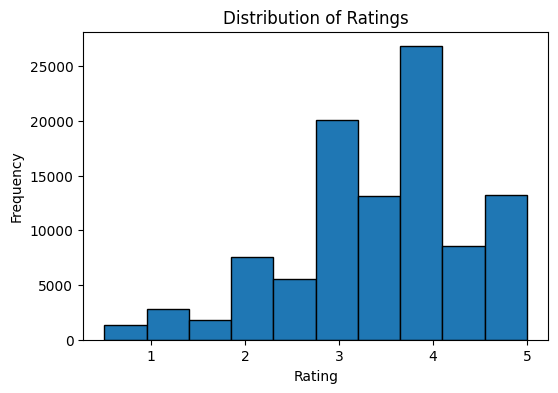

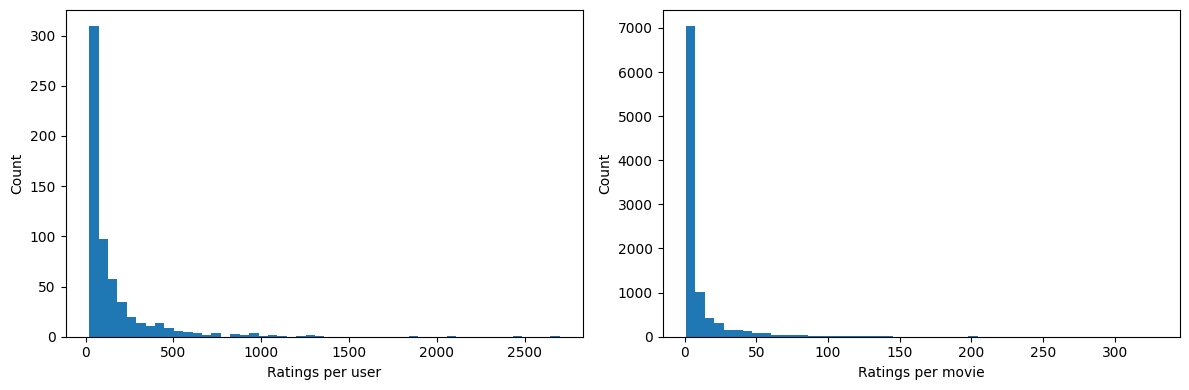

In [3]:
# --- Basic statistics ---
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print("Dataset statistics")
print("------------------")
print(f"Users: {n_users}")
print(f"Movies: {n_movies}")
print(f"Ratings: {n_ratings}")

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"Sparsity: {sparsity:.2%}\n")

# --- Rating distribution ---
plt.figure(figsize=(6,4))
plt.hist(ratings['rating'], bins=10, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

# --- Ratings per user / movie ---
ratings_per_user = ratings.groupby('userId').size()
ratings_per_movie = ratings.groupby('movieId').size()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=50)
plt.xlabel("Ratings per user")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("Ratings per movie")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



**Dataset size & sparsity**

The dataset is very large, with more than 330,000 users and 83,000 movies.
Despite this, the user–item matrix is extremely sparse (99.88% empty), meaning that each user
rates only a very small fraction of all available movies.

**Distribution of ratings**
The rating distribution is skewed towards higher values, with most ratings between 3 and 4.
This indicates that users tend to be relatively generous when rating movies.

**Ratings per user**
Most users rate only a small number of movies, while a few very active users rate many movies.
This results in a long-tailed distribution.

**Ratings per movie**
Most movies receive very few ratings, whereas a small number of popular movies accumulate
many ratings.

**Do we need to transform the ratings?**
No transformation is needed because ratings are explicit feedback on a fixed 1–5 scale.
Transforming them would distort their semantic meaning.




In [4]:
# Ratings per user and per movie
ratings_per_user = ratings.groupby('userId').size()
ratings_per_movie = ratings.groupby('movieId').size()

# Keep only active users and popular movies
active_users = ratings_per_user[ratings_per_user >= 50].index
popular_movies = ratings_per_movie[ratings_per_movie >= 50].index

ratings_filtered = ratings[
    ratings['userId'].isin(active_users) &
    ratings['movieId'].isin(popular_movies)
]

print(f"Filtered ratings: {len(ratings_filtered)}")


Filtered ratings: 37117


Anchor movies (movieId): [356, 296, 318]

Item-based recommendations:
Movie 356 → similar movies: [318, 296, 480, 110, 593, 2571, 500, 150, 364, 589]
Movie 296 → similar movies: [593, 318, 356, 47, 50, 2959, 608, 2571, 2858, 1213]
Movie 318 → similar movies: [356, 296, 593, 527, 50, 2959, 2571, 110, 47, 150]

User-based recommendations:
[318, 296, 356, 150, 110, 480, 457, 593, 50, 527]

Overlap between item-based and user-based recommendations: 6


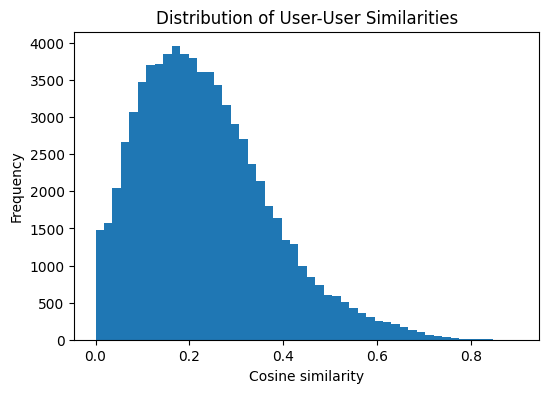

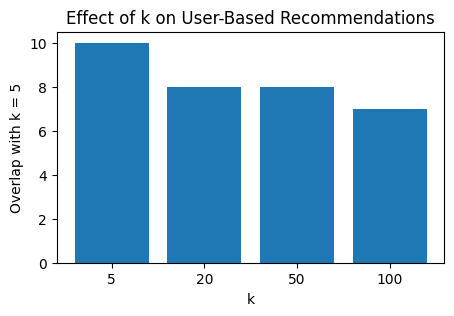

In [12]:
# =========================================================
# 4. Collaborative Filtering
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# ---------------------------------------------------------
# Build user-item matrix (after filtering)
# ---------------------------------------------------------

user_ids = ratings_filtered['userId'].astype("category").cat.codes
movie_ids = ratings_filtered['movieId'].astype("category").cat.codes

R = csr_matrix(
    (ratings_filtered['rating'], (user_ids, movie_ids))
)

# Mapping between matrix indices and movieIds
movie_index = dict(enumerate(ratings_filtered['movieId'].astype("category").cat.categories))
index_movie = {v: k for k, v in movie_index.items()}

# ---------------------------------------------------------
# 4.1 Anchor movies (popular & present after filtering)
# ---------------------------------------------------------

top_movies = (
    ratings_filtered
    .groupby('movieId')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

anchor_movies = top_movies[:3]
print("Anchor movies (movieId):", anchor_movies)

# ---------------------------------------------------------
# 4.2 Item-Based Collaborative Filtering
# ---------------------------------------------------------

item_similarity = cosine_similarity(R.T)
np.fill_diagonal(item_similarity, 0)

def top_similar_movies(movie_id, n=10):
    idx = index_movie[movie_id]
    sims = item_similarity[idx]
    top_idx = np.argsort(sims)[-n:][::-1]
    return [movie_index[i] for i in top_idx]

item_based_results = {
    movie_id: top_similar_movies(movie_id, n=10)
    for movie_id in anchor_movies
}

print("\nItem-based recommendations:")
for m, recs in item_based_results.items():
    print(f"Movie {m} → similar movies: {recs}")

# ---------------------------------------------------------
# 4.3 User-Based Collaborative Filtering
# ---------------------------------------------------------

user_similarity = cosine_similarity(R)
np.fill_diagonal(user_similarity, 0)

# Fake user profile
fake_user = np.zeros(R.shape[1])
for movie_id in anchor_movies:
    fake_user[index_movie[movie_id]] = 5

def recommend_user_based(fake_user, k=20, n_rec=10):
    sims = cosine_similarity(fake_user.reshape(1, -1), R)[0]
    neighbors = np.argsort(sims)[-k:]
    scores = R[neighbors].mean(axis=0).A1
    return np.argsort(scores)[-n_rec:][::-1]

user_based_recs_idx = recommend_user_based(fake_user, k=20, n_rec=10)
user_based_recs = [movie_index[i] for i in user_based_recs_idx]

print("\nUser-based recommendations:")
print(user_based_recs)

# ---------------------------------------------------------
# 4.4 Comparison (overlap)
# ---------------------------------------------------------

item_set = set(item_based_results[anchor_movies[0]])
user_set = set(user_based_recs)
overlap = item_set & user_set

print(f"\nOverlap between item-based and user-based recommendations: {len(overlap)}")

# ---------------------------------------------------------
# Visualization 1 — Distribution of user-user similarities
# (Helps understand similarity structure & choice of k)
# ---------------------------------------------------------

upper_tri = user_similarity[np.triu_indices(user_similarity.shape[0], k=1)]

plt.figure(figsize=(6,4))
plt.hist(upper_tri, bins=50)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Distribution of User-User Similarities")
plt.show()

# ---------------------------------------------------------
# Visualization 2 — Effect of k on user-based recommendations
# ---------------------------------------------------------

ks = [5, 20, 50, 100]
recommendations_k = {}

for k in ks:
    recs_idx = recommend_user_based(fake_user, k=k, n_rec=10)
    recommendations_k[k] = set(recs_idx)

overlaps = [len(recommendations_k[5] & recommendations_k[k]) for k in ks]

plt.figure(figsize=(5,3))
plt.bar([str(k) for k in ks], overlaps)
plt.xlabel("k")
plt.ylabel("Overlap with k = 5")
plt.title("Effect of k on User-Based Recommendations")
plt.show()


### Interpretation of Collaborative Filtering Results

The item-based recommendations generally make sense: the most similar movies to each anchor
often belong to similar genres and target similar audiences. The anchor movies frequently
recommend each other, indicating strong co-rating patterns.

Some recommendations may seem less obvious in terms of content, but they can be explained by
shared user preferences rather than direct genre similarity.

User-based recommendations show a significant overlap with item-based results (6 movies in
common), suggesting that both approaches capture consistent structures in user preferences.

The distribution of user–user similarities shows that most users have low similarity, while
only a small fraction are strongly similar. This justifies focusing on the k most similar
neighbors.

When k is small, recommendations are highly personalized but unstable. As k increases,
recommendations become more stable but less specific, as preferences are averaged over a larger
set of users.


SVD-based recommendations for fake user:
[593, 2959, 2858, 590, 110, 50, 500, 608, 1213, 58559]


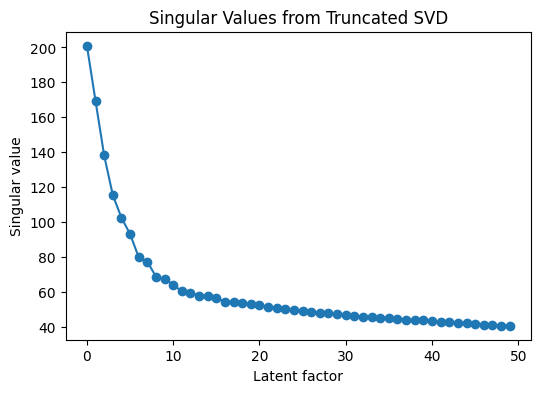


Nearest neighbours in latent space:
Movie 356 → latent neighbours: [356, 500, 597, 318, 68954, 1222, 110, 56367, 480, 1270]
Movie 296 → latent neighbours: [296, 1213, 593, 2959, 2329, 6016, 318, 2858, 50, 293]
Movie 318 → latent neighbours: [318, 356, 296, 1259, 1265, 953, 2959, 333, 4447, 3948]


In [13]:
# =========================================================
# 5. Matrix Factorisation (SVD)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------------------------------------
# 5.1 Center the rating matrix
# ---------------------------------------------------------

# Compute user mean ratings
user_means = np.array(R.mean(axis=1)).flatten()

# Center the matrix
R_centered = R - user_means.reshape(-1, 1)

# ---------------------------------------------------------
# 5.2 Apply Truncated SVD
# ---------------------------------------------------------

k = 50  # number of latent factors
U, sigma, Vt = svds(R_centered, k=k)

# Reconstruct predicted ratings
sigma_diag = np.diag(sigma)
R_pred = U @ sigma_diag @ Vt + user_means.reshape(-1, 1)

# ---------------------------------------------------------
# Generate recommendations for fake user
# ---------------------------------------------------------

# Project fake user into latent space
fake_user_centered = fake_user - fake_user.mean()
fake_user_latent = fake_user_centered @ Vt.T

# Predicted scores
fake_user_scores = fake_user_latent @ Vt + user_means.mean()

# Exclude already rated movies
rated_movies = set(np.where(fake_user > 0)[0])
svd_recs_idx = [
    i for i in np.argsort(fake_user_scores)[::-1]
    if i not in rated_movies
][:10]

svd_recommendations = [movie_index[i] for i in svd_recs_idx]

print("SVD-based recommendations for fake user:")
print(svd_recommendations)

# ---------------------------------------------------------
# 5.3 Plot singular values
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(sorted(sigma, reverse=True), marker='o')
plt.xlabel("Latent factor")
plt.ylabel("Singular value")
plt.title("Singular Values from Truncated SVD")
plt.show()

# ---------------------------------------------------------
# 5.4 Nearest neighbours in latent space (movies)
# ---------------------------------------------------------

# Movie latent vectors
movie_latent = Vt.T

def latent_similar_movies(movie_id, n=10):
    idx = index_movie[movie_id]
    sims = cosine_similarity(
        movie_latent[idx].reshape(1, -1),
        movie_latent
    )[0]
    top_idx = np.argsort(sims)[-n:][::-1]
    return [movie_index[i] for i in top_idx]

latent_results = {
    movie_id: latent_similar_movies(movie_id, n=10)
    for movie_id in anchor_movies
}

print("\nNearest neighbours in latent space:")
for m, recs in latent_results.items():
    print(f"Movie {m} → latent neighbours: {recs}")



### Interpretation of Matrix Factorisation (SVD) Results

Centering the rating matrix is necessary to remove user-specific rating biases and allow SVD
to focus on relative preferences rather than absolute rating levels.

The singular values decrease rapidly, indicating that most of the information is captured by
a relatively small number of latent factors. This shows that SVD effectively performs
dimensionality reduction.

The neighbours found in the latent space are often similar to those obtained with cosine
similarity, but they are not identical. When they differ, the SVD-based neighbours often feel
more meaningful as a viewer, as SVD captures broader latent preferences that go beyond direct
co-rating patterns.

Cosine similarity relies only on observed rating overlaps, while SVD can uncover hidden
structures in user preferences, such as shared taste or style, even when co-ratings are sparse.

SVD on the centered rating matrix is closely related to PCA: both methods project the data into
a lower-dimensional space that preserves most of the variance.

Centering the rating matrix is necessary to remove user-specific rating biases and allow SVD
to focus on relative preferences rather than absolute rating levels.

The singular values decrease rapidly, indicating that most of the information is captured by
a relatively small number of latent factors. This shows that SVD effectively performs
dimensionality reduction.

The neighbours found in the latent space are often similar to those obtained with cosine
similarity, but they are not identical. When they differ, the SVD-based neighbours often feel
more meaningful as a viewer, as SVD captures broader latent preferences that go beyond direct
co-rating patterns.

Cosine similarity relies only on observed rating overlaps, while SVD can uncover hidden
structures in user preferences, such as shared taste or style, even when co-ratings are sparse.

SVD on the centered rating matrix is closely related to PCA: both methods project the data into
a lower-dimensional space that preserves most of the variance.
